# Выбор места для отрытия кафе

__Постановка задачи:__

Провести анализ рынка для открытия нового кафе в Москве и дать рекомендации: район, количество мест, вид заведения.

In [1]:
# подключение библиотек
import pandas as pd
import numpy as np

import scipy.stats as stats
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns

large = 24; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 8),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': small,
          'ytick.labelsize': small,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

<a id='id_1'></a>
## Загрузка и предобработка данных

In [2]:
# получение данных
data = pd.read_csv('r_data.csv', sep=',')
data.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [3]:
# обзор данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


In [4]:
# проверка неявных дубликатов
display(data['chain'].value_counts())
data['object_type'].value_counts()

нет    12398
да      2968
Name: chain, dtype: int64

кафе                                 6099
столовая                             2587
ресторан                             2285
предприятие быстрого обслуживания    1923
бар                                   856
буфет                                 585
кафетерий                             398
закусочная                            360
магазин (отдел кулинарии)             273
Name: object_type, dtype: int64

In [5]:
# проверка явных дубликатов
data.duplicated(subset=['object_name', 'chain', 'object_type', 'address', 'number']).sum()

82

In [6]:
# удаление явных дубликатов в строках
#data.drop_duplicates(subset=['object_name', 'chain', 'object_type', 'address', 'number']).reset_index(drop=True)

Вывод: пропусков данных нет, неявные дубликаты проверены - кроме наименований и адресов объектов.

<a id='id_2'></a>
## Анализ рынка

<a id='id_2_1'></a>
### Анализ видов объектов общественного питания

In [7]:
# сводная таблица по видам объектов
data_object_type = (
    data.groupby('object_type', as_index=False).agg({'id': 'count'})
    .rename(columns={'id': 'count_object_type'})
    .sort_values(by='count_object_type', ascending=False)
).reset_index(drop=True)
data_object_type

,object_type,count_object_type
0,кафе,6099
1,столовая,2587
2,ресторан,2285
3,предприятие быстрого обслуживания,1923
4,бар,856
5,буфет,585
6,кафетерий,398
7,закусочная,360
8,магазин (отдел кулинарии),273


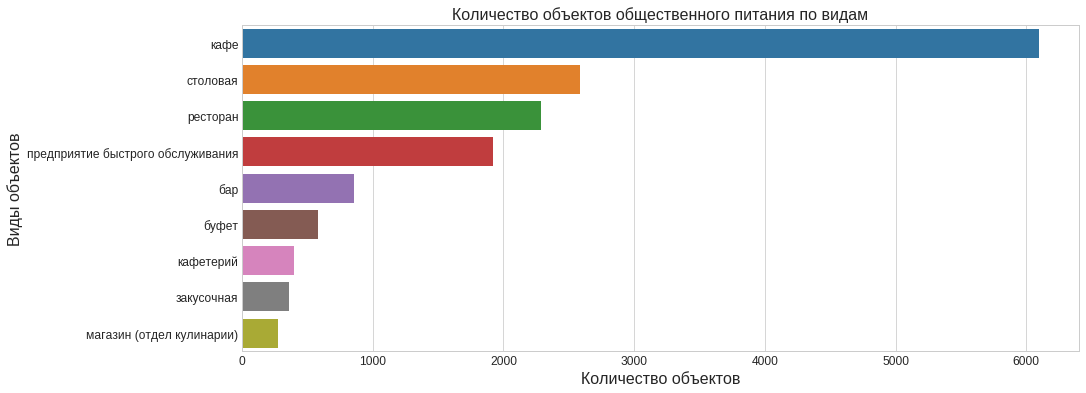

In [8]:
# диаграмма количества объектов
f, ax = plt.subplots(figsize=(15, 6))
ax = sns.barplot(y='object_type', x='count_object_type', data=data_object_type)
ax.set_title('Количество объектов общественного питания по видам')
ax.set_xlabel('Количество объектов')
ax.set_ylabel('Виды объектов')
plt.show()

In [9]:
# доля кафе на рынке заведений
object_sum = data_object_type['count_object_type'].sum()
cafe_sum = data_object_type[data_object_type['object_type'] == 'кафе']['count_object_type'].sum()
round(cafe_sum / object_sum, 2), object_sum

(0.4, 15366)

Вывод: рынок объектов общественного питания Москвы составляет 15 тыс. ед., из них наибольшая доля приходится на кафе - 40%.

<a id='id_2_2'></a>
### Анализ сетевых заведений

In [10]:
# Отношение количеств несетевых магазинов к сетевым
data['chain_b'] = data['chain'] == 'да'


In [11]:
# доля сетевых заведений
round(data['chain_b'].mean(), 2)

0.19

In [12]:
# расчет количества сетевых заведений
data_chain = data.groupby('chain', as_index=False).agg({'id': 'count'}).rename(columns={'id': 'count_chain_type'})
data_chain

,chain,count_chain_type
0,да,2968
1,нет,12398


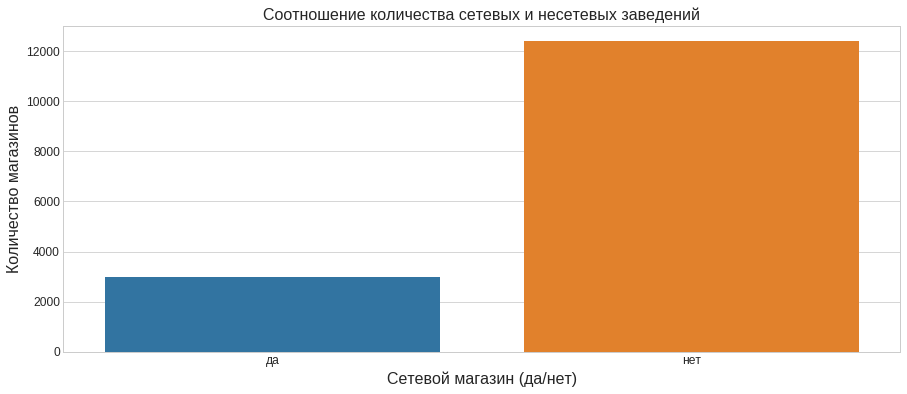

In [13]:
f, ax = plt.subplots(figsize=(15, 6))
ax = sns.barplot(x='chain', y='count_chain_type', data=data_chain)
ax.set_title('Cоотношение количества сетевых и несетевых заведений')
ax.set_xlabel('Сетевой магазин (да/нет)')
ax.set_ylabel('Количество магазинов')
plt.show()

Вывод: наибольшая доля рынка приходится на несетевые объекты - 81%. На сетевые объекты общественного питания приходится 19% рынка.

Исследуем для какого вида объекта общественного питания характерно сетевое распространение:

In [14]:
data.head()

,id,object_name,chain,object_type,address,number,chain_b
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,False
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,False
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,False
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,True
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,False


In [15]:
data_chain_all = data['chain_b'].sum()
data_chain_sum = (data
 .groupby('object_type')
 .agg({'chain_b': 'sum', 'id': 'count'})
 .rename(columns={'chain_b': 'chain_sum', 'id': 'chain_count'})
 .sort_values(by='chain_sum', ascending=False)
)
data_chain_sum['chain_ratio'] = round(data_chain_sum['chain_sum'] / data_chain_all, 2)
data_chain_sum['chain_object_ratio'] = round(data_chain_sum['chain_sum'] / data_chain_sum['chain_count'], 2)
data_chain_sum.sort_values(by='chain_object_ratio', ascending=False)

,chain_sum,chain_count,chain_ratio,chain_object_ratio
object_type,,,,
предприятие быстрого обслуживания,791.0,1923,0.27,0.41
магазин (отдел кулинарии),78.0,273,0.03,0.29
ресторан,544.0,2285,0.18,0.24
кафе,1396.0,6099,0.47,0.23
закусочная,56.0,360,0.02,0.16
кафетерий,52.0,398,0.02,0.13
бар,37.0,856,0.01,0.04
буфет,11.0,585,0.00,0.02
столовая,3.0,2587,0.00,0.00


Вывод: наибольшая доля рынка сетевых объектов приходится на кафе - 47% и предприятия быстрого питания - 27%, что охватывает 3/4 рынка сетевых объектов. При этом сетевое распространение наиболее характерно для предприятий быстрого обслуживания - 41% таких предприятий являютя сетевыми, в то время как только 23% всех кафе сетевые.

<a id='id_2_3'></a>
### Анализ количества посадочных мест

In [16]:
# срез сетевых заведений
data_chain_all = data.query('chain_b == True')

In [17]:
#  проверка уникальности наименований сетевых заведений
name = data_chain_all['object_name'].sort_values().unique()
display(name)

array(['Beverly Hills Diner', 'Bierloga', 'Black & White', 'Bocconcino',
       'BooBo', 'Bubbleology', 'Burger Club', 'COFIX', 'CORREAS',
       'CoffeeShop', 'Coffeeshop Company', 'Cofix', 'Cookhouse',
       'Correas', 'Costa Coffee', 'Deli by Prime Прайм-кафе',
       'Dunkin Donuts', 'FRIDAYS', 'Florentini', 'Fridays KFC',
       'GRAND УРЮК', 'GlowSubs Sandwiches', 'Goodman Гудман', 'Grand Cru',
       'HEALTHY Food', 'Healthy Food', 'Healthy food',
       'IL Forno Иль Форно', 'Jeffreys Coffee', 'Jeffreys coffee', 'KFC',
       'KFC Волгоградский', 'Krispy Creme', 'Krispy Krem', 'LAVKALAVKA',
       'Luciano', 'M Cafe Хинкальная', 'Maki Maki', 'Marmalato',
       'Marrakesh Хинкальная', 'MosKalyan', 'Movenpick', 'My box',
       'Osteria Mario', 'PAUL Поль', 'PRIME STAR Прайм стар',
       'PRIME Прайм стар Прайм-кафе', 'Panda Express', 'Pizengof99 СПБ',
       'Prime Прайм стар', 'STARBUCKS COFFEE', 'SUBWAY', 'Starbucks',
       'Starbucks Старбакс', 'Starbucks кофе', 'Starbuck

In [18]:
# удаление неявных дубликатов наименований
synonyms = {
    '': [
        'кафе ',
        'кафе-закусочная ',
        'кафе-пекарея ',
        'каффе ',
        'кондитерия ',
        'кондитерская-пекарня ',
        'корчма ',
        'кофейня ',
        'пиццерия ',
        'предприятие быстрого обслуживания ',
        'ресторан ',
        'кофе',
        'coffee',
        'цех по изготовлению пиццы',
        'закусочная ',
        'кофешоп ',
        'пицца',
        'праймкафе',
        '«',
        '»'
        ],
    'кулинарное бюро китчен': 'кулинарное бюро kitchen',
    '«кулинарная лавка братьев караваевых»': ['«кулинарная лавка братьев караваевых»»', 'кулинарная лавка братьев караваевых братья караваевы'],
    'burger king': 'бургер кинг',
    'starbucks': 'старбакс',
    'star': 'стар',
    'prime': 'прайм'
}

def check_synonyms(cell):
    for name, syn in synonyms.items():
        if cell in syn: return name.strip()
    return cell
data_chain_all['object_name_new'] = data_chain_all['object_name'].apply(check_synonyms)
data_chain_all.head()

,id,object_name,chain,object_type,address,number,chain_b,object_name_new
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,True,ПИЦЦЕТОРИЯ
6,148815,Брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10,True,Брусника
13,22579,Алло Пицца,да,кафе,"город Москва, улица Авиаторов, дом 14",32,True,Алло Пицца
16,144107,Суши Wok,да,предприятие быстрого обслуживания,"город Москва, Азовская улица, дом 3",7,True,Суши Wok
18,58565,Тануки,да,ресторан,"город Москва, Большая Академическая улица, дом 65",160,True,Тануки


In [19]:
# расчет количества сетевых заведений и среднего количества мест в заведении
data_chain_all_number = (data_chain_all
 .groupby(['object_type', 'object_name_new'], as_index=False)
 .agg({'number': 'mean', 'id': 'count'})
 .rename(columns={'number': 'number_mean', 'id': 'count_object_name'})
 .sort_values(by='object_type', ascending=False)
).reset_index(drop=True)
data_chain_all_number['object_name_new'] = data_chain_all_number['object_name_new'].str.lower()
data_chain_all_number

,object_type,object_name_new,number_mean,count_object_name
0,столовая,му-му,55.000000,1
1,столовая,гурман,162.000000,1
2,столовая,грабли,120.000000,1
3,ресторан,иль патио,133.947368,19
4,ресторан,золотая вобла,89.000000,1
...,...,...,...,...
962,бар,фитнес-бар «world class»,25.000000,1
963,бар,хинкальная,30.000000,1
964,бар,шикари иль патио,11.000000,1
965,бар,шоколадница,150.000000,1


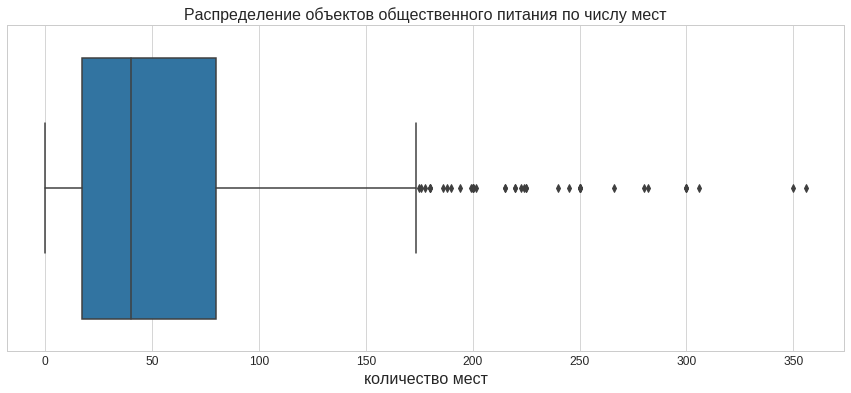

In [20]:
# диаграмма распределения среднего количества мест в сетевых заведениях
f, ax = plt.subplots(figsize=(15, 6))
ax = sns.boxplot(x='number_mean', data=data_chain_all_number)
ax.set_title('Распределение объектов общественного питания по числу мест')
ax.set_xlabel('количество мест')
plt.show()

In [21]:
# расчет квартилей среднего количества посадочных мест в сетевых заведениях
data_chain_all_number['number_mean'].quantile([0.25,0.5,0.75])

0.25    17.326667
0.50    40.000000
0.75    80.000000
Name: number_mean, dtype: float64

Вывод: в сетевых заведениях в среднем 40 мест, первый квартиль 17 мест, третий квартиль 80 мест.

In [22]:
# категорирование среднего числа мест в сетевых заведениях
def metod(row_values):
    if row_values['number_mean'] <= 17:
        result = 'мало'
    elif 17 < row_values['number_mean'] <= 40:
        result = 'ниже среднего'
    elif 40 < row_values['number_mean'] <= 80:
        result = 'выше среднего'
    else:
        result = 'много'
    return result

data_chain_all_number['number_mean_group'] = data_chain_all_number.apply(metod, axis=1)
data_chain_all_number

,object_type,object_name_new,number_mean,count_object_name,number_mean_group
0,столовая,му-му,55.000000,1,выше среднего
1,столовая,гурман,162.000000,1,много
2,столовая,грабли,120.000000,1,много
3,ресторан,иль патио,133.947368,19,много
4,ресторан,золотая вобла,89.000000,1,много
...,...,...,...,...,...
962,бар,фитнес-бар «world class»,25.000000,1,ниже среднего
963,бар,хинкальная,30.000000,1,ниже среднего
964,бар,шикари иль патио,11.000000,1,мало
965,бар,шоколадница,150.000000,1,много


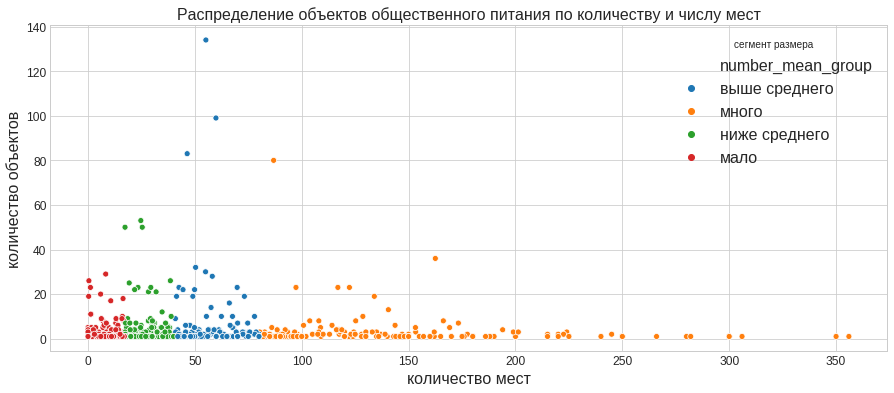

In [23]:
f, ax = plt.subplots(figsize=(15, 6))
ax = sns.scatterplot(y='count_object_name', x='number_mean', hue='number_mean_group', data=data_chain_all_number)
ax.set_title('Распределение объектов общественного питания по количеству и числу мест')
ax.set_xlabel('количество мест')
ax.set_ylabel('количество объектов')
ax.legend(title="сегмент размера")
plt.show()

Вывод: масштабируются обычно сети с необольшим количеством мест - до 80, т.о. для сетевых заведений характерно большое количество объектов с небольшим количеством мест. 

Проанализируем количество посадочных мест по видам объектов.

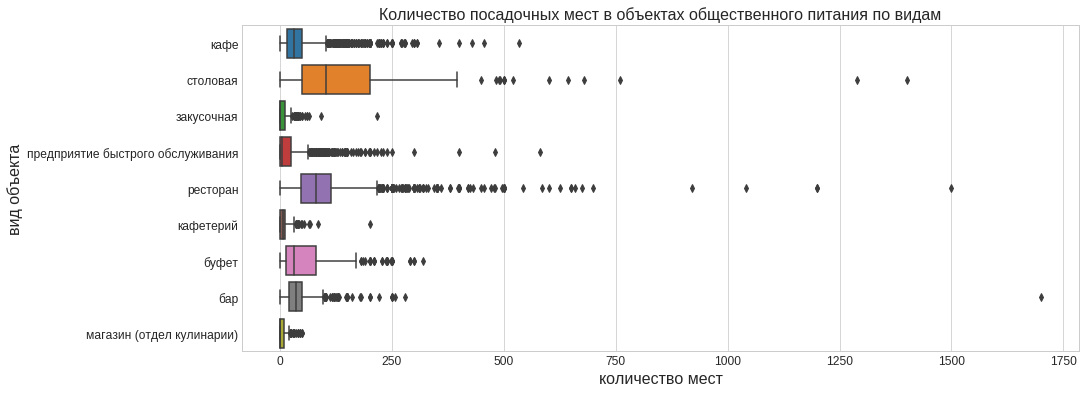

In [24]:
# расчет количества посадочных мест по видам объектов
f, ax = plt.subplots(figsize=(15, 6))
ax = sns.boxplot(y='object_type', x='number', data=data)
ax.set_title('Количество посадочных мест в объектах общественного питания по видам')
ax.set_xlabel('количество мест')
ax.set_ylabel('вид объекта')
plt.show()

Вывод: наибольшее количество посадочных мест у ресторанов и столовых.

In [25]:
# средее количество посадочных мест по видам объектов
data_mean = (data
 .groupby(['object_type'], as_index=False)
 .agg({'number': 'mean'})
 .rename(columns={'number': 'number_mean'})
 .sort_values(by='number_mean', ascending=False)
).reset_index(drop=True)
data_mean

,object_type,number_mean
0,столовая,130.246618
1,ресторан,96.834136
2,буфет,51.129915
3,бар,43.494159
4,кафе,39.716019
5,предприятие быстрого обслуживания,20.552262
6,кафетерий,9.123116
7,закусочная,7.608333
8,магазин (отдел кулинарии),5.589744


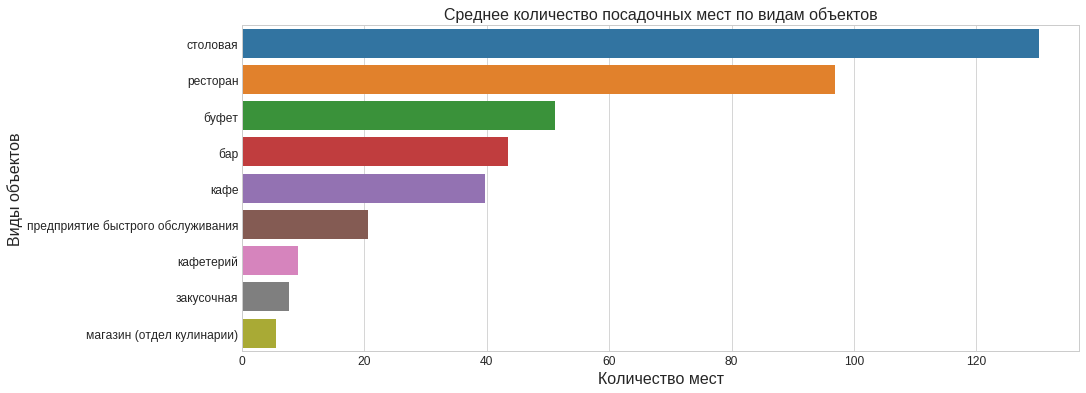

In [26]:
f, ax = plt.subplots(figsize=(15, 6))
ax = sns.barplot(y='object_type', x='number_mean', data=data_mean)
ax.set_title('Cреднее количество посадочных мест по видам объектов')
ax.set_xlabel('Количество мест')
ax.set_ylabel('Виды объектов')
plt.show()

Вывод: среднее количество посадочных мест больше для столовых - в среднем 130, ресторанов - 97 и буфетов - 51.

<a id='id_2_4'></a>
### Анализ места расположения

In [27]:
# подсчет количества уникальных слов в адресе для выделения маркеров улиц
from collections import Counter
result = Counter(" ".join(data['address'].values.tolist()).split(" ")).items()
result

dict_items([('город', 15698), ('Москва,', 15295), ('улица', 3657), ('Егора', 3), ('Абакумова,', 3), ('дом', 14841), ('9', 216), ('Талалихина,', 9), ('2/1,', 36), ('корпус', 2770), ('1', 3716), ('Абельмановская', 3), ('улица,', 5431), ('6', 336), ('Абрамцевская', 12), ('9,', 178), ('15,', 125), ('переулок', 13), ('Сивцев', 4), ('Вражек,', 6), ('6/2', 10), ('Авиамоторная', 31), ('8,', 193), ('строение', 4154), ('47', 32), ('49/1', 1), ('51', 39), ('Авиаторов,', 8), ('14', 153), ('16', 182), ('18', 170), ('Азовская', 24), ('3', 844), ('4', 592), ('Большая', 514), ('Академическая', 19), ('65', 4), ('Филипповский', 1), ('переулок,', 712), ('15/5', 1), ('Алтайская', 5), ('33/7', 1), ('Алтуфьевское', 84), ('шоссе,', 1277), ('42Б', 3), ('56', 55), ('102Б', 1), ('Амундсена,', 5), ('10', 282), ('Анадырский', 10), ('проезд,', 703), ('55', 25), ('Ангарская', 6), ('1,', 335), ('2', 1717), ('39', 45), ('проспект', 478), ('Андропова,', 79), ('17,', 109), ('26', 172), ('30', 58), ('35А', 3), ('38,', 2

In [28]:
# список слов-маркеров для определения поля с улицей
purpose_street = ['улица', 'переулок', 'проезд', 'бульвар', 'проспект', 'шоссе', 'площадь', 'квартал', 'микрорайон']

In [29]:
# выделение поля улицы
def street_extr(cell):
    # перебор элементов поля address
    for i in range(2):
        # перебор маркеров улицы
        for j in purpose_street:
            if j in cell.split(',')[i]:
                street = cell.split(',')[i]
                street = street.lower()
                street = street.strip()
                return street    

data['address_street'] = data['address'].apply(street_extr)
data.head()                           


,id,object_name,chain,object_type,address,number,chain_b,address_street
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,False,улица егора абакумова
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,False,улица талалихина
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,False,абельмановская улица
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,True,абрамцевская улица
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,False,абрамцевская улица


In [30]:
# топ-10 улиц по количеству заведений
data_street_10 = (data
 .groupby('address_street', as_index=False)
 .agg({'id': 'count'})
 .rename(columns={'id': 'number_object'})
 .sort_values(by='number_object', ascending=False)
).reset_index(drop=True).head(10)
data_street_10['address_street'] = data_street_10['address_street'].str.lower()
data_street_10['address_street'] = data_street_10['address_street'].str.strip()
data_street_10

,address_street,number_object
0,проспект мира,204
1,профсоюзная улица,183
2,ленинградский проспект,173
3,варшавское шоссе,162
4,ленинский проспект,148
5,проспект вернадского,132
6,кутузовский проспект,114
7,каширское шоссе,112
8,кировоградская улица,110
9,ходынский бульвар,102


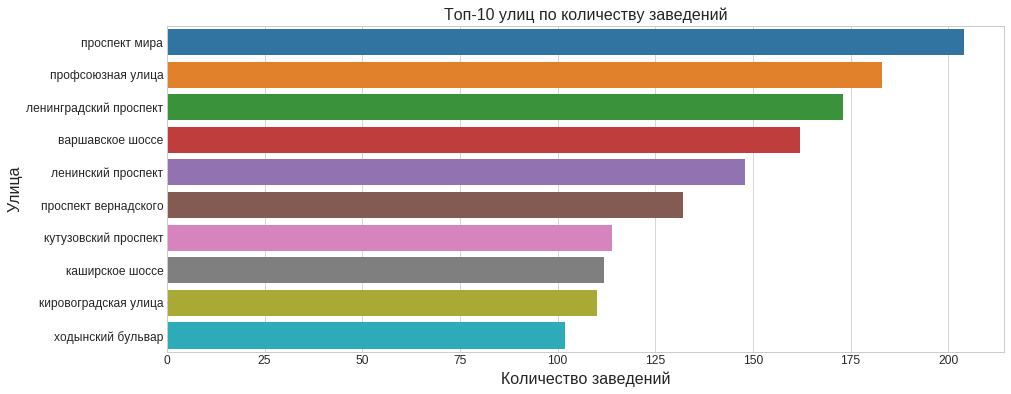

In [31]:
f, ax = plt.subplots(figsize=(15, 6))
ax = sns.barplot(y='address_street', x='number_object', data=data_street_10)
ax.set_title('Топ-10 улиц по количеству заведений')
ax.set_xlabel('Количество заведений')
ax.set_ylabel('Улица')
plt.show()

Вывод: в ТОП-10 кроме улиц Москвы вошли также город Зеленоград (1 место) и поселение Сосенское.

Определим принадлежность ТОП-10 улиц Москвы к районам.

In [32]:
# загрузка данных о районах Москвы
from io import BytesIO
import requests

spredsheet_id = '18VQikQqtZ-OeHZVLVUonDsirqo91y24_8qqH18Kqhq0'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spredsheet_id)
r = requests.get(file_name)
df_district = pd.read_csv(BytesIO(r.content))
df_district['streetname'] = df_district['streetname'].str.lower()
df_district['streetname'] = df_district['streetname'].str.strip()
df_district.head()

,streetname,areaid,okrug,area
0,выставочный переулок,17,ЦАО,Пресненский район
1,улица гашека,17,ЦАО,Пресненский район
2,большая никитская улица,17,ЦАО,Пресненский район
3,глубокий переулок,17,ЦАО,Пресненский район
4,большой гнездниковский переулок,17,ЦАО,Пресненский район


In [33]:
# районы Москвы где расположены топ-10 улиц
data_street_10_area = data_street_10.merge(df_district, left_on='address_street', right_on='streetname', how='left')
data_street_10_area_lst = data_street_10_area.query('address_street not in ["город зеленоград", "поселение сосенское"]')['area'].unique()
data_street_10_area_lst

array(['Алексеевский район', 'Ярославский Район', 'Район Марьина роща',
       'Останкинский район', 'Район Ростокино', 'Район Свиблово',
       'Мещанский район', 'Академический район', 'Район Черемушки',
       'Район Ясенево', 'Район Коньково', 'Обручевский район',
       'Район Теплый Стан', 'Район Аэропорт', 'Район Беговой',
       'Хорошевский район', 'Район Сокол', 'Район Чертаново Центральное',
       'Район Чертаново Северное', 'Район Чертаново Южное',
       'Донской район', 'Район Нагатино-Садовники', 'Нагорный район',
       'Район Северное Бутово', 'Район Южное Бутово',
       'Район Проспект Вернадского', 'Район Тропарево-Никулино',
       'Район Гагаринский', 'Ломоносовский район', 'Район Якиманка',
       'Район Раменки', 'Район Дорогомилово', 'Район Фили-Давыдково',
       'Район Москворечье-Сабурово', 'Район Орехово-Борисово Южное',
       'Район Орехово-Борисово Северное'], dtype=object)

Вывод: определен перечень районов Москвы с расположенными улицами ТОП-10.

Определим районы Москвы с улицами с единственным заведением общественного питания.

In [34]:
# улицы с одним заведением
data_street_1 = ((data
 .groupby('address_street', as_index=False)
 .agg({'id': 'count'})
 .rename(columns={'id': 'number_object'})
 .sort_values(by='number_object', ascending=False)
).reset_index(drop=True)).query('number_object == "1"')
data_street_1['address_street'] = data_street_1['address_street'].str.lower()
data_street_1['address_street'] = data_street_1['address_street'].str.strip()
data_street_1

,address_street,number_object
1242,библиотечная улица,1
1243,улица ращупкина,1
1244,улица ремизова,1
1245,улица подвойского,1
1246,бескудниковский проезд,1
...,...,...
1742,лечебная улица,1
1743,линейный проезд,1
1744,лонгиновская улица,1
1745,лосевская улица,1


In [35]:
# дополниние таблицы с улицами одного заведения полем с районами Москвы
data_street_1_area = data_street_1.merge(df_district, left_on='address_street', right_on='streetname', how='left')
data_street_1_area

,address_street,number_object,streetname,areaid,okrug,area
0,библиотечная улица,1,библиотечная улица,18.0,ЦАО,Таганский район
1,улица ращупкина,1,улица ращупкина,41.0,ЗАО,Можайский Район
2,улица ремизова,1,улица ремизова,127.0,ЮЗАО,Район Котловка
3,улица подвойского,1,улица подвойского,17.0,ЦАО,Пресненский район
4,бескудниковский проезд,1,бескудниковский проезд,56.0,САО,Бескудниковский Район
...,...,...,...,...,...,...
545,лечебная улица,1,лечебная улица,36.0,ВАО,Район Соколиная Гора
546,линейный проезд,1,линейный проезд,67.0,САО,Тимирязевский Район
547,лонгиновская улица,1,лонгиновская улица,114.0,ЮВАО,Район Лефортово
548,лосевская улица,1,лосевская улица,86.0,СВАО,Ярославский Район


In [36]:
# удаление неполных данных
data_street_1_area.dropna(subset=['area'], inplace=True)
data_street_1_area

,address_street,number_object,streetname,areaid,okrug,area
0,библиотечная улица,1,библиотечная улица,18.0,ЦАО,Таганский район
1,улица ращупкина,1,улица ращупкина,41.0,ЗАО,Можайский Район
2,улица ремизова,1,улица ремизова,127.0,ЮЗАО,Район Котловка
3,улица подвойского,1,улица подвойского,17.0,ЦАО,Пресненский район
4,бескудниковский проезд,1,бескудниковский проезд,56.0,САО,Бескудниковский Район
...,...,...,...,...,...,...
545,лечебная улица,1,лечебная улица,36.0,ВАО,Район Соколиная Гора
546,линейный проезд,1,линейный проезд,67.0,САО,Тимирязевский Район
547,лонгиновская улица,1,лонгиновская улица,114.0,ЮВАО,Район Лефортово
548,лосевская улица,1,лосевская улица,86.0,СВАО,Ярославский Район


In [37]:
# перечень районо Москвы с улицами с одним заведением
data_street_1_area['area'].unique()

array(['Таганский район', 'Можайский Район', 'Район Котловка',
       'Пресненский район', 'Бескудниковский Район',
       'Нижегородский район', 'Басманный район', 'Район Замоскворечье',
       'Район Якиманка', 'Район Богородское', 'Мещанский район',
       'Район Арбат', 'Район Фили-Давыдково', 'Район Южное Бутово',
       'Район Внуково', 'Район Южное Тушино', 'Тверской район',
       'Район Соколиная Гора', 'Район Хамовники', 'Район Раменки',
       'Район Лефортово', 'Район Хорошево-Мневники', 'Район Ростокино',
       'Красносельский район', 'Район Текстильщики', 'Алексеевский район',
       'Район Дорогомилово', 'Район Очаково-Матвеевское', 'Район Люблино',
       'Район Сокольники', 'Район Марьина роща', 'Район Аэропорт',
       'Район Сокол', 'Хорошевский район', 'Бабушкинский район',
       'Тимирязевский Район', 'Ярославский Район', 'Район Отрадное',
       'Нагорный район', 'Лосиноостровский район', 'Дмитровский район',
       'Район Метрогородок', 'Рязанский район', 'Райо

Вывод: определен перечень районов Москвы включающие улицы с одним заведением общественног питания.

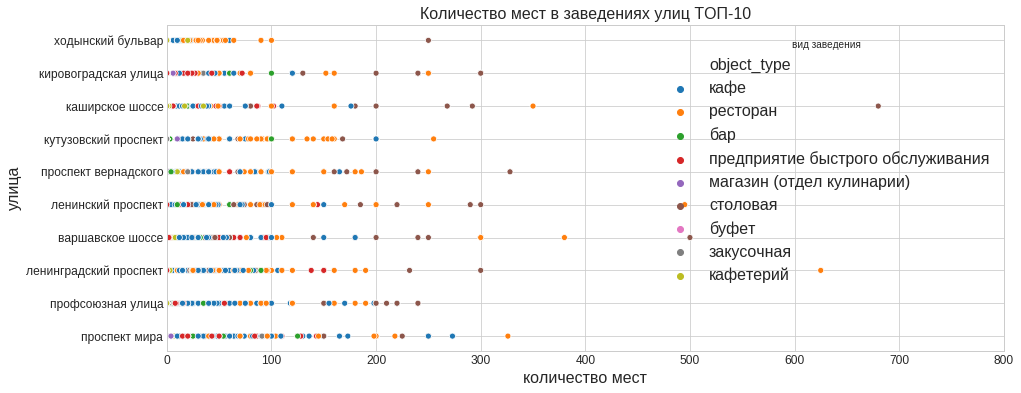

In [38]:
# распределение заведений в зависимости от количества посадочных мест и улицы
data_top10_number = data_street_10.merge(data, left_on='address_street', right_on='address_street', how='left')

f, ax = plt.subplots(figsize=(15, 6))
ax = sns.scatterplot(y='address_street', x='number', hue='object_type', data=data_top10_number)
ax.set_title('Количество мест в заведениях улиц ТОП-10')
ax.set_xlabel('количество мест')
ax.set_ylabel('улица')
ax.legend(title="вид заведения")
ax.set_xlim([0, 800])
plt.show()

Выводы: на улицах ТОП-10 наибольшее количество объектов с небольшим количеством посадочных мест до 50 - 100. 

<a id='id_3'></a>
## Выводы и рекомендации

__Предобработка данных:__

Предобработка данных показала, что в данных о заказах нет пропусков, форматы данных корректны. Удалены 86 полных дубликатов. Выявлены неявные дубликаты в наименовании сетевых объектов общественного питания.

__Анализ данных:__

Анализ данных показал, что представлены данные по городу Москве, городу Зеленоград и поселению Сосенское.

Реузультаты анализа рынка общественного питания:

- рынок объектов общественного питания составляет 15 тыс. ед., из них наибольшая доля приходится на кафе - 40%;
- наибольшая доля рынка приходится на несетевые объекты - 81%, на сетевые объекты общественного питания приходится 19% рынка;
- наибольшая доля рынка сетевых объектов приходится на кафе - 47% и предприятия быстрого питания - 27%, что охватывает 3/4 рынка сетевых объектов, однако сетевое распространение наиболее характерно для предприяти быстрого питания;
- в сетевых заведениях в среднем 40 мест, первый квартиль 17 мест, третий квартиль 80 мест;
-  масштабируются обычно сети с небольшим количеством мест - до 80, т.о. для сетевых заведений характерно большое количество объектов с небольшим количеством мест;
- наибольшее количество посадочных мест у ресторанов, столовых и буфетов: среднее количество посадочных мест в столовых - 130, в ресторанах - 97, в буфетах - 51;
- определены ТОП-10 улиц с наибольшим количеством заведений, к ним также отнесены город Зеленоград (1 место) и поселение Сосенское;
- определены районы Москвы с улицами из ТОП-10;
- определены районы Москвы с улицами с единственным заведением общественного питания;
- на улицах ТОП-10 наибольшее количество объектов с небольшим количеством посадочных мест до 50 - 100.

__Рекомендации:__

1. Учитывая высокую конкурентность заведений общественного питания в Москве, для принятия решения об открытии нового кафе рекомендуется определить ключевые конкурентные преимущества и стратегию конкурирования.
2. Выделим три возможные стратегии конкурирования - жесткое конкурирование в ключевых района, умеренное конкурирование в неключевых района и избегание конкурирования в районах без конкуренции. Учитывая возможные конкурентные преимущества в виде снижения расходов на оплату труда официантов, сокращение времени обслуживания, снижение ошибок обслуживания и отмену чаевых - предлагается обратить внимание на стратегию с жесткой конкуренцией - размещение заведения по списку районов ТОП-10.
3. Для использования конкурентных преимуществ рекомендуется обратить внимание на вид заведения кафе, имеющий потенциал к масштабированию и работающий в сегменте небольшого количества посадочных мест - до 80. Нижняя граница количества посадочных мест будет определена экономикой проекта.
4. При успешном пилотном проекте возможно дальнейшее масштабирование в соответствии с выбранной стратегией.